In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

Loading images from the following paths:
Low Resolution Image Path: /kaggle/input/lr-hr-sr/Dataset/LR/sample1.npy
High Resolution Image Path: /kaggle/input/lr-hr-sr/Dataset/HR/sample1.npy

Low Resolution Image Information:
Shape: (1, 75, 75)
Dimensions: 3
Data Type: float64
Min Value: 0.004476010581607796
Max Value: 0.9734353589372715

High Resolution Image Information:
Shape: (1, 150, 150)
Dimensions: 3
Data Type: float64
Min Value: 0.0
Max Value: 1.0



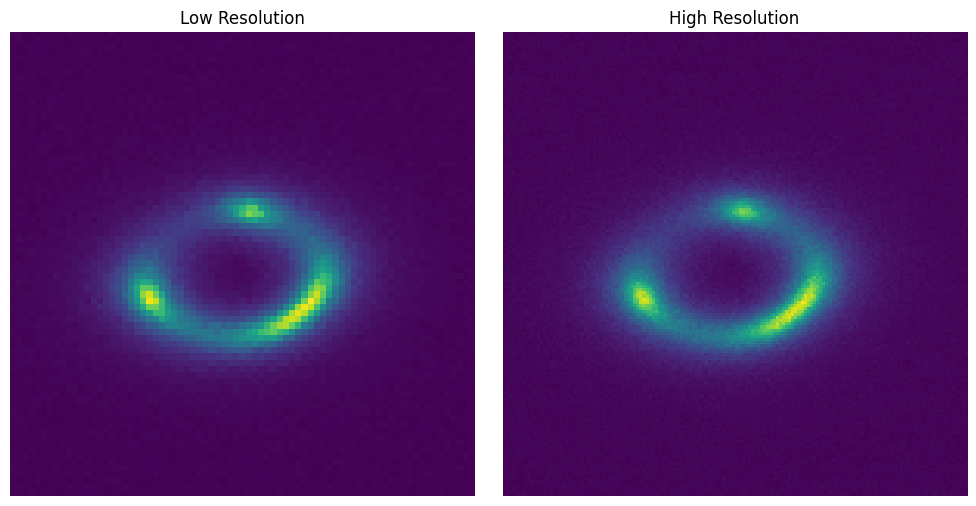

In [2]:
# Define the file paths for the low-resolution and high-resolution images
lr_image_path = '/kaggle/input/lr-hr-sr/Dataset/LR/sample1.npy'
hr_image_path = '/kaggle/input/lr-hr-sr/Dataset/HR/sample1.npy'

# Print the addresses of the images
print("Loading images from the following paths:")
print(f"Low Resolution Image Path: {lr_image_path}")
print(f"High Resolution Image Path: {hr_image_path}")
print()

# Load the low-resolution and high-resolution images
lr_image = np.load(lr_image_path)
hr_image = np.load(hr_image_path)

# Print information about the low-resolution image
print("Low Resolution Image Information:")
print(f"Shape: {lr_image.shape}")
print(f"Dimensions: {lr_image.ndim}")
print(f"Data Type: {lr_image.dtype}")
print(f"Min Value: {lr_image.min()}")
print(f"Max Value: {lr_image.max()}")
print()

# Print information about the high-resolution image
print("High Resolution Image Information:")
print(f"Shape: {hr_image.shape}")
print(f"Dimensions: {hr_image.ndim}")
print(f"Data Type: {hr_image.dtype}")
print(f"Min Value: {hr_image.min()}")
print(f"Max Value: {hr_image.max()}")
print()

# Check if the images are grayscale or RGB
if lr_image.ndim == 2:  # Grayscale
    lr_image = np.expand_dims(lr_image, axis=-1)  # Add channel dimension
if hr_image.ndim == 2:  # Grayscale
    hr_image = np.expand_dims(hr_image, axis=-1)  # Add channel dimension

# Create a figure to display the images
plt.figure(figsize=(10, 5))

# Display the low-resolution image
plt.subplot(1, 2, 1)
plt.imshow(lr_image.squeeze(), cmap='gray' if lr_image.shape[-1] == 1 else None)
plt.title('Low Resolution')
plt.axis('off')

# Display the high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(hr_image.squeeze(), cmap='gray' if hr_image.shape[-1] == 1 else None)
plt.title('High Resolution')
plt.axis('off')

# Show the images
plt.tight_layout()
plt.show()

Loading images from the following paths:
Low Resolution Image Path: /kaggle/input/sr-tunedata/Dataset/LR/LR_1.npy
High Resolution Image Path: /kaggle/input/sr-tunedata/Dataset/HR/HR_1.npy

Low Resolution Image Information:
Shape: (1, 64, 64)
Dimensions: 3
Data Type: float32
Min Value: -0.00440429151058197
Max Value: 0.9987027645111084

High Resolution Image Information:
Shape: (1, 128, 128)
Dimensions: 3
Data Type: float32
Min Value: 0.0018911075312644243
Max Value: 1.0107526779174805



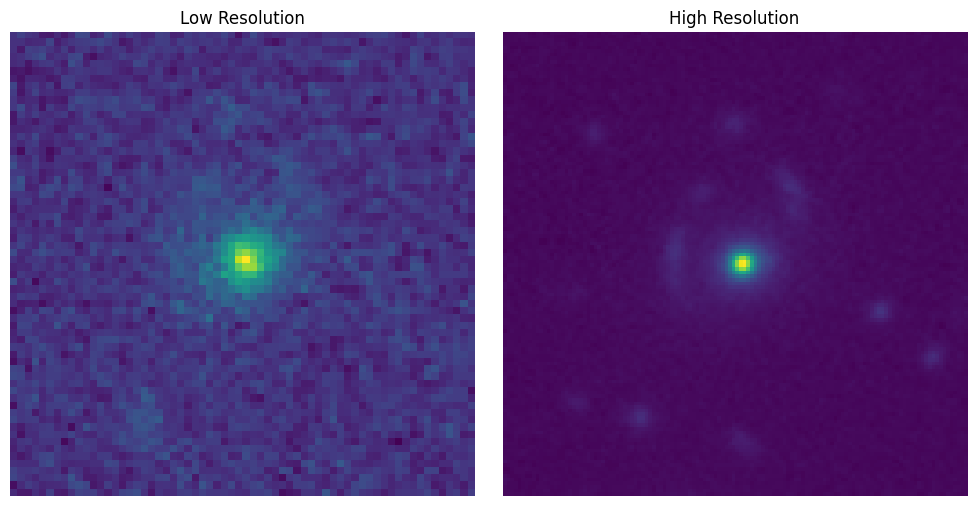

In [3]:
# Define the file paths for the low-resolution and high-resolution images
hr_image_path = '/kaggle/input/sr-tunedata/Dataset/HR/HR_1.npy'
lr_image_path = '/kaggle/input/sr-tunedata/Dataset/LR/LR_1.npy'

# Print the addresses of the images
print("Loading images from the following paths:")
print(f"Low Resolution Image Path: {lr_image_path}")
print(f"High Resolution Image Path: {hr_image_path}")
print()

# Load the low-resolution and high-resolution images
lr_image = np.load(lr_image_path)
hr_image = np.load(hr_image_path)

# Print information about the low-resolution image
print("Low Resolution Image Information:")
print(f"Shape: {lr_image.shape}")
print(f"Dimensions: {lr_image.ndim}")
print(f"Data Type: {lr_image.dtype}")
print(f"Min Value: {lr_image.min()}")
print(f"Max Value: {lr_image.max()}")
print()

# Print information about the high-resolution image
print("High Resolution Image Information:")
print(f"Shape: {hr_image.shape}")
print(f"Dimensions: {hr_image.ndim}")
print(f"Data Type: {hr_image.dtype}")
print(f"Min Value: {hr_image.min()}")
print(f"Max Value: {hr_image.max()}")
print()

# Check if the images are grayscale or RGB
if lr_image.ndim == 2:  # Grayscale
    lr_image = np.expand_dims(lr_image, axis=-1)  # Add channel dimension
if hr_image.ndim == 2:  # Grayscale
    hr_image = np.expand_dims(hr_image, axis=-1)  # Add channel dimension

# Create a figure to display the images
plt.figure(figsize=(10, 5))

# Display the low-resolution image
plt.subplot(1, 2, 1)
plt.imshow(lr_image.squeeze(), cmap='gray' if lr_image.shape[-1] == 1 else None)
plt.title('Low Resolution')
plt.axis('off')

# Display the high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(hr_image.squeeze(), cmap='gray' if hr_image.shape[-1] == 1 else None)
plt.title('High Resolution')
plt.axis('off')

# Show the images
plt.tight_layout()
plt.show()

In [4]:
transform_low = transforms.Compose([
    transforms.ToTensor(),  # Converts numpy (H, W, C) to tensor (C, H, W)
])

transform_high = transforms.Compose([
    transforms.ToTensor(),
])


In [5]:
class NPYImageDataset(Dataset):
    def __init__(self, root_dir):
        super(NPYImageDataset, self).__init__()
        self.low_res_dir = os.path.join(root_dir, "LR")
        self.high_res_dir = os.path.join(root_dir, "HR")
        
        self.files = sorted(os.listdir(self.low_res_dir))  # Assumes same filenames in LR/HR
        self.files = [f for f in self.files if f.endswith('.npy')]
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file_name = self.files[index]
        low_res_path = os.path.join(self.low_res_dir, file_name)
        high_res_path = os.path.join(self.high_res_dir, file_name)

        # Load .npy images
        low_res = np.load(low_res_path)  # shape: (1, 75, 75)
        high_res = np.load(high_res_path)  # shape: (1, 150, 150)

        # Convert to (H, W, C)
        low_res = np.moveaxis(low_res, 0, -1)  # (75, 75, 1)
        high_res = np.moveaxis(high_res, 0, -1)  # (150, 150, 1)

        # Convert 1-channel to 3-channel by repeating
        if low_res.shape[2] == 1:
            low_res = np.repeat(low_res, 3, axis=2)
        if high_res.shape[2] == 1:
            high_res = np.repeat(high_res, 3, axis=2)

        # Normalize float64 to float32 and apply transforms
        low_res = transform_low(low_res.astype(np.float32))
        high_res = transform_high(high_res.astype(np.float32))

        return low_res, high_res

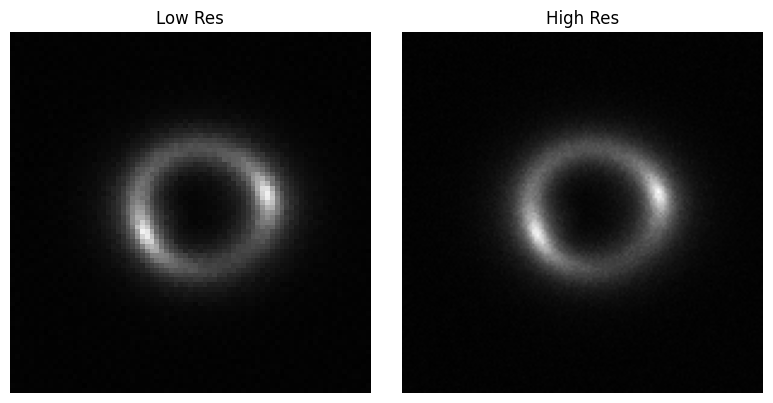

In [6]:
# Show low-res and high-res pair
def show_image():
    dataset = NPYImageDataset(root_dir="/kaggle/input/lr-hr-sr/Dataset")
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for low_res, high_res in loader:
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("Low Res")
        axs[0].axis("off")

        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("High Res")
        axs[1].axis("off")
        break

    plt.tight_layout()
    plt.show()

show_image()


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 30
batch_size = 16
num_workers = 2
img_channels = 3

In [8]:
# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 212MB/s] 


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [9]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [10]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [11]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [13]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [15]:
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def plot_examples(gen):
    dataset_test = NPYImageDataset(root_dir="/kaggle/input/lr-hr-sr/Dataset")
    loader = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=2)

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Randomly select a batch and an image
    chosen_batch = random.randint(0, len(loader) - 1)

    for idx, (low_res, high_res) in enumerate(loader):
        if idx == chosen_batch:
            chosen = random.randint(0, len(low_res) - 1)

            # Plot low resolution image
            axs[0].imshow(low_res[chosen].permute(1, 2, 0).cpu().numpy())
            axs[0].set_title("Low Res")
            axs[0].axis("off")

            # Generate predicted high-resolution image
            with torch.no_grad():
                gen.eval()
                upscaled_img = gen(low_res[chosen].unsqueeze(0).to(device))

            # Plot predicted high resolution
            axs[1].imshow(upscaled_img.squeeze(0).permute(1, 2, 0).cpu().numpy())
            axs[1].set_title("Predicted")
            axs[1].axis("off")

            # Plot ground truth high resolution image
            axs[2].imshow(high_res[chosen].permute(1, 2, 0).cpu().numpy())
            axs[2].set_title("High Res")
            axs[2].axis("off")

            break  # only one example is shown

    plt.tight_layout()
    plt.show()
    gen.train()


In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [17]:
# define the generator / discriminator / and other hyperparameters (not already defined above)
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [18]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

In [19]:
# Train dataset and loader
train = NPYImageDataset(root_dir="/kaggle/input/lr-hr-sr/Dataset")
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# If you have a separate validation set, update path accordingly.
# Otherwise, use train set for both train/val just to test the pipeline
val = NPYImageDataset(root_dir="/kaggle/input/lr-hr-sr/Dataset")
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)

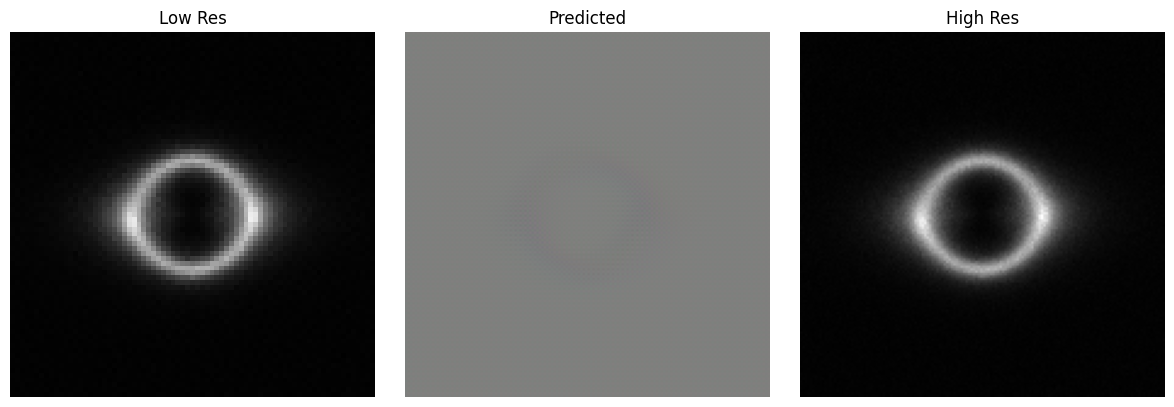

epoch  1 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

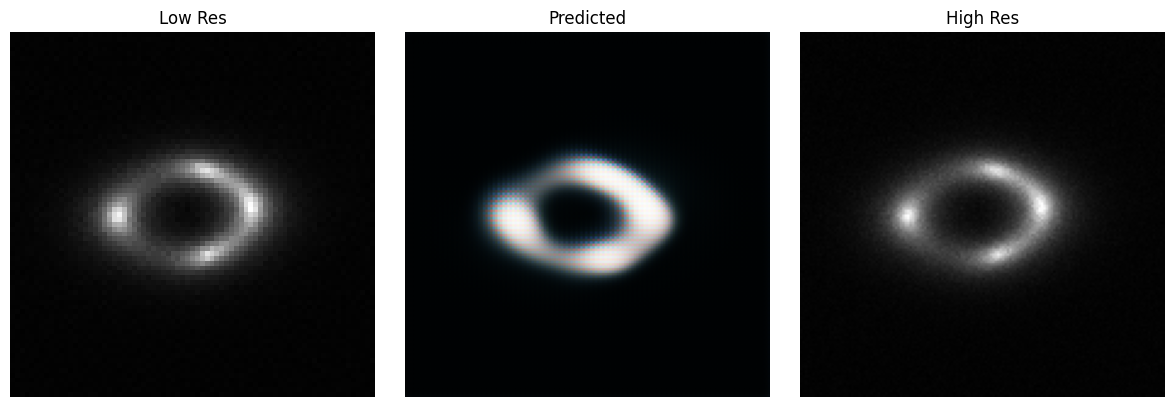

epoch  2 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

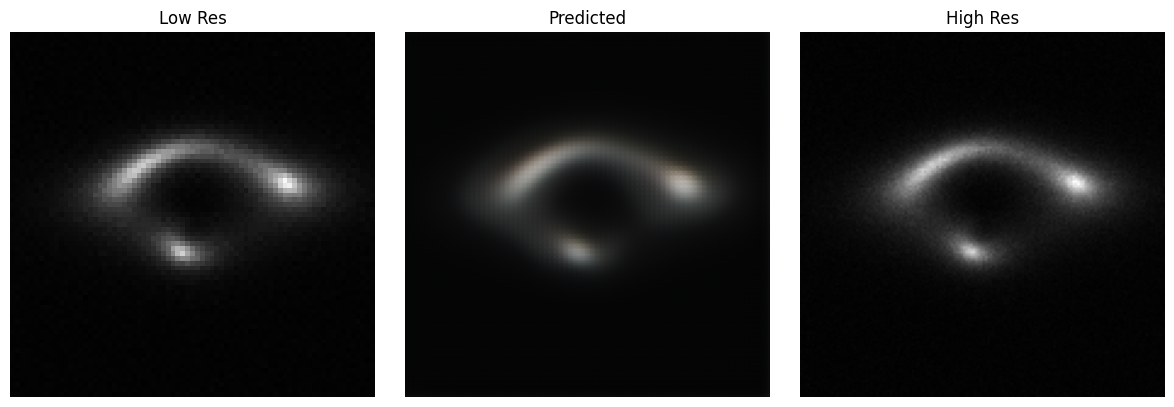

epoch  3 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

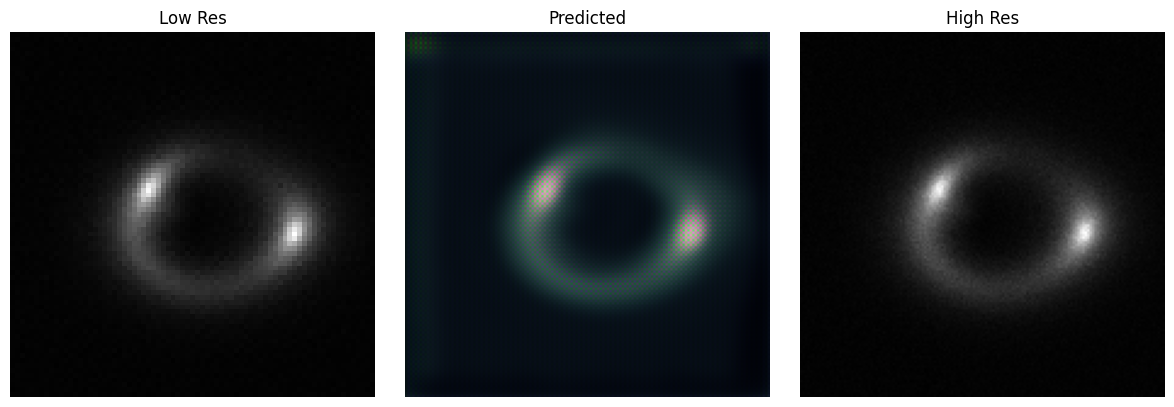

epoch  4 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

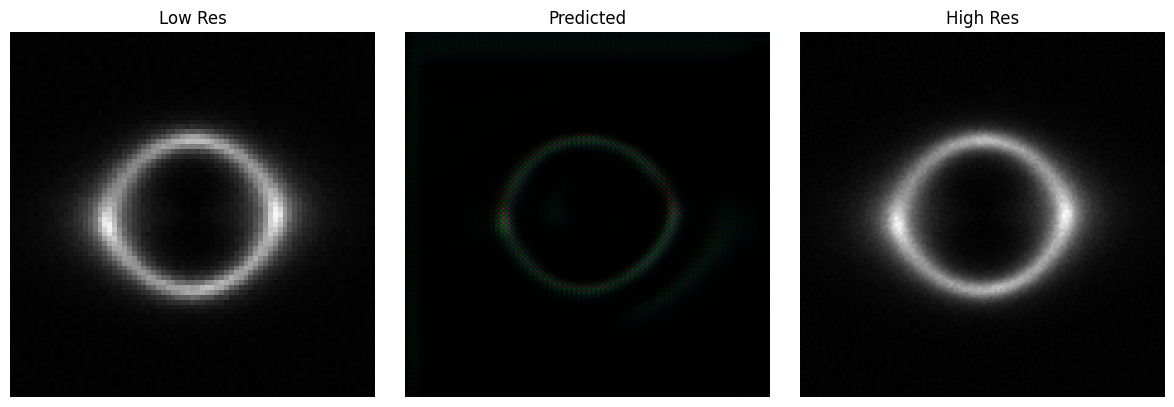

epoch  5 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

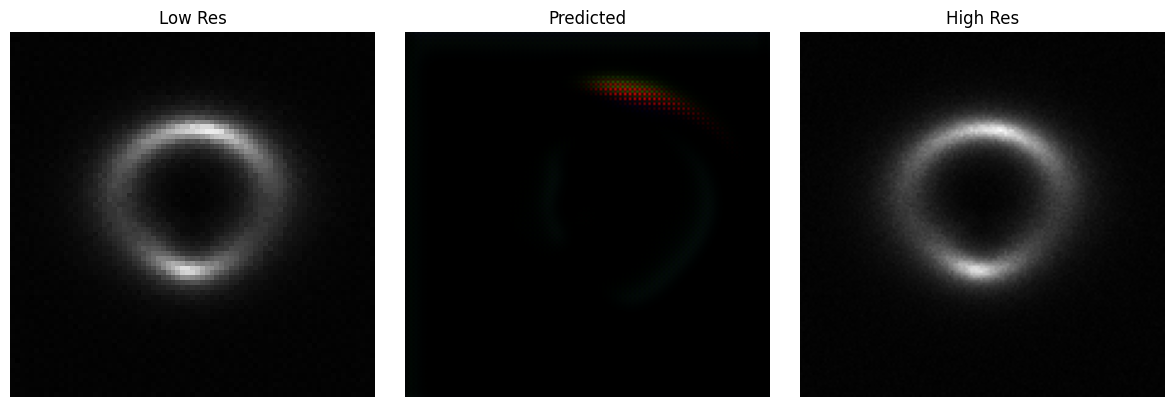

epoch  6 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

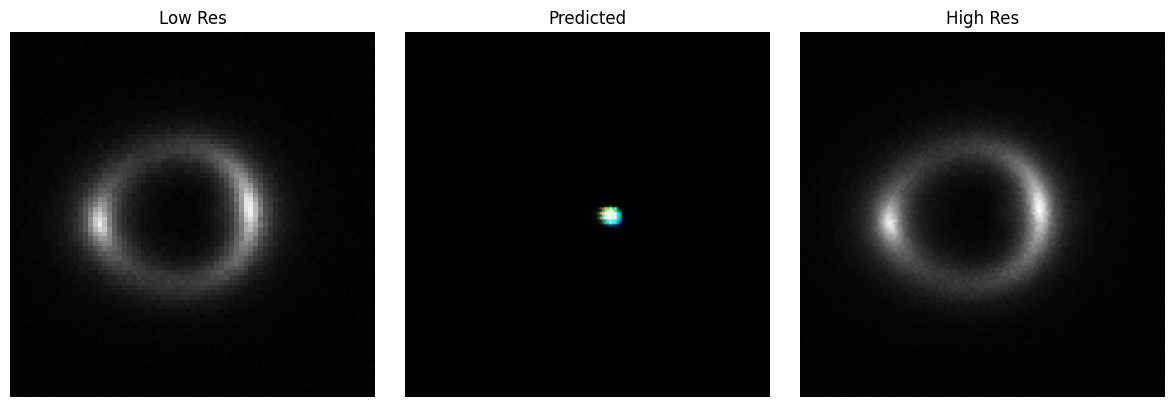

epoch  7 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

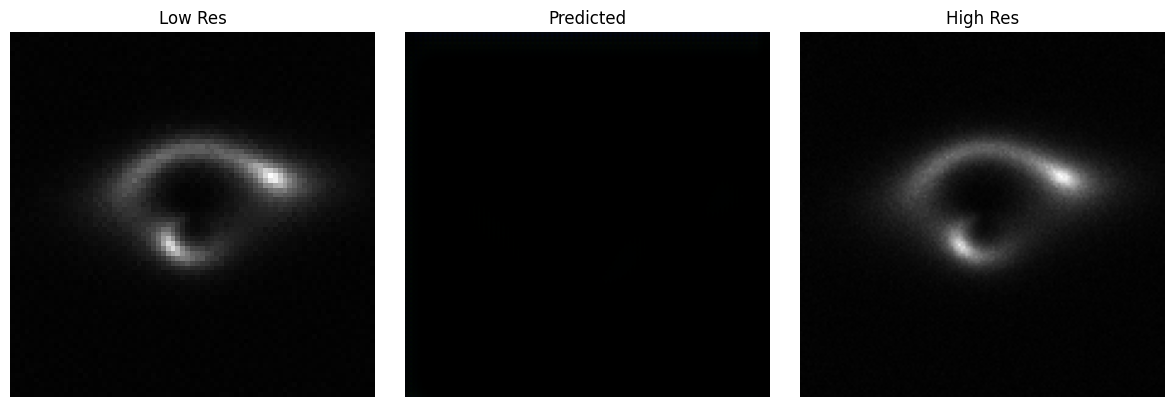

epoch  8 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

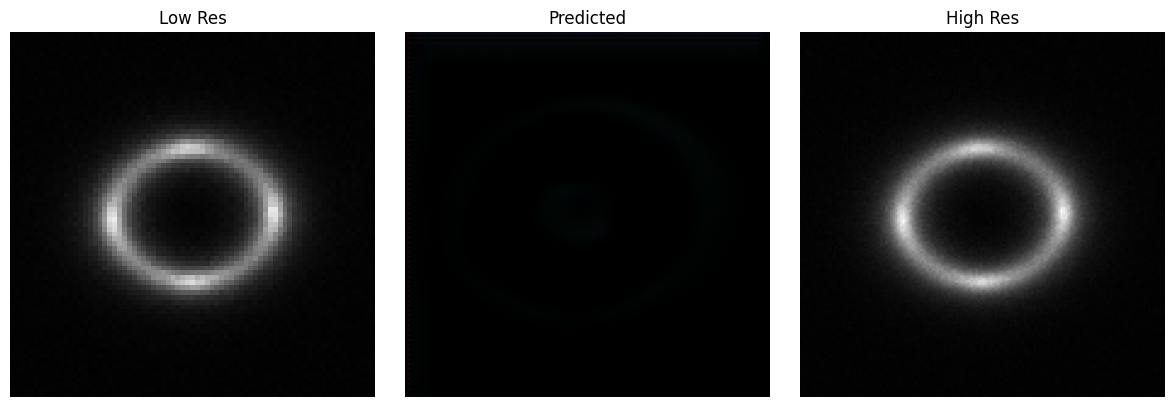

epoch  9 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

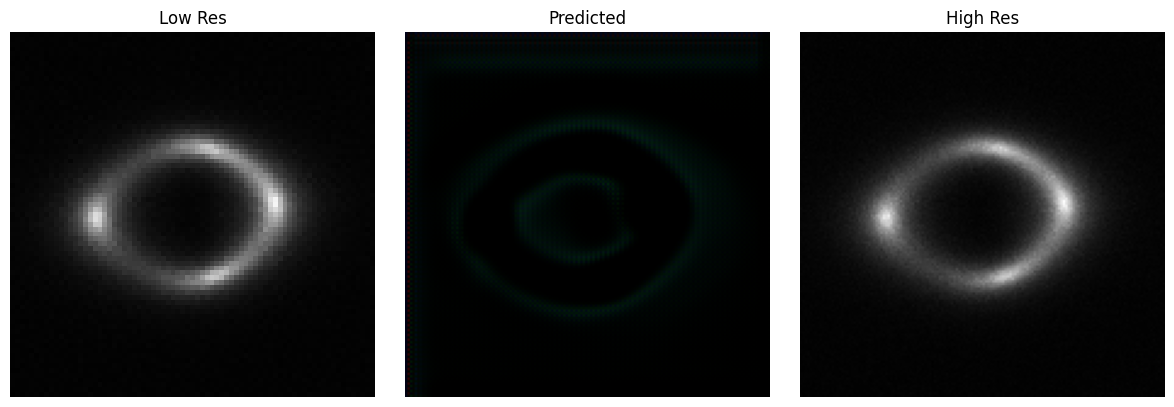

epoch  10 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

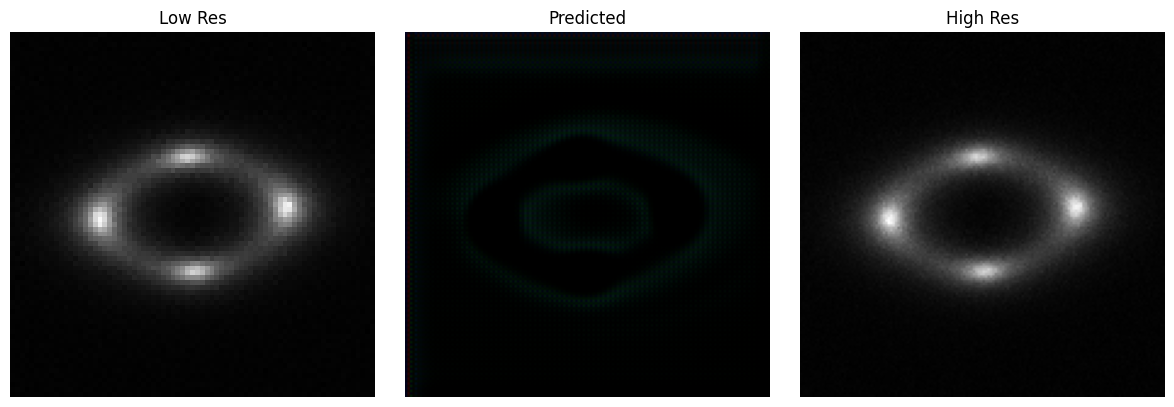

epoch  11 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

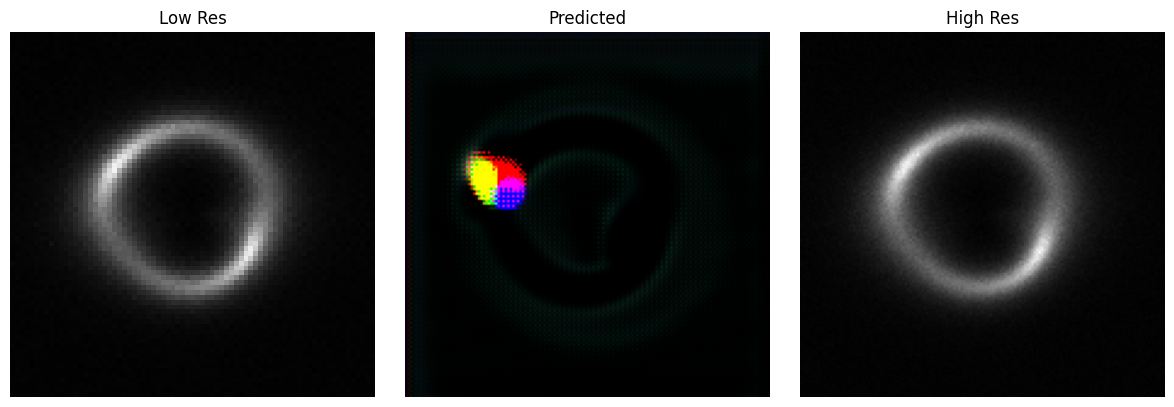

epoch  12 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

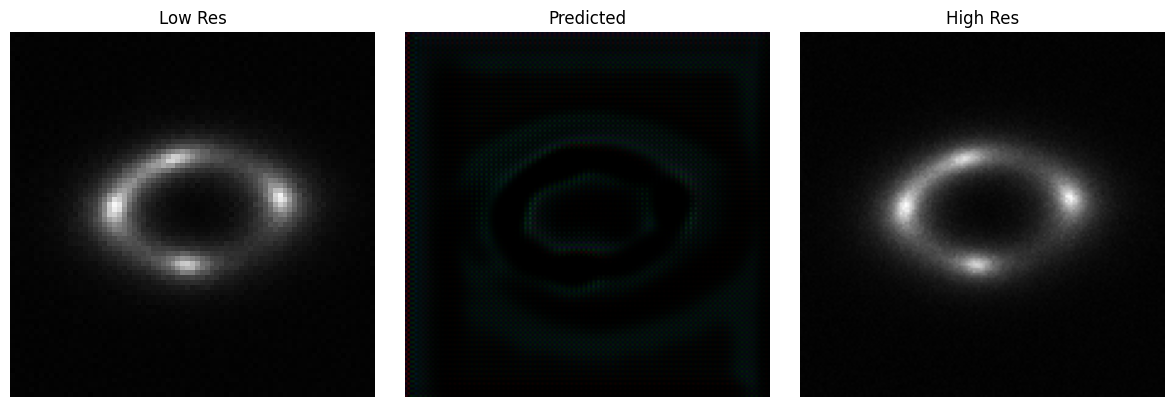

epoch  13 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

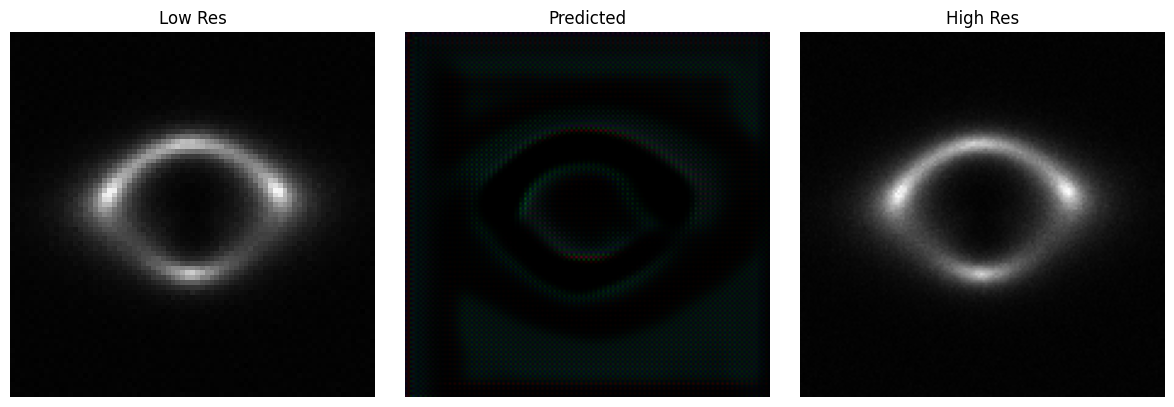

epoch  14 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

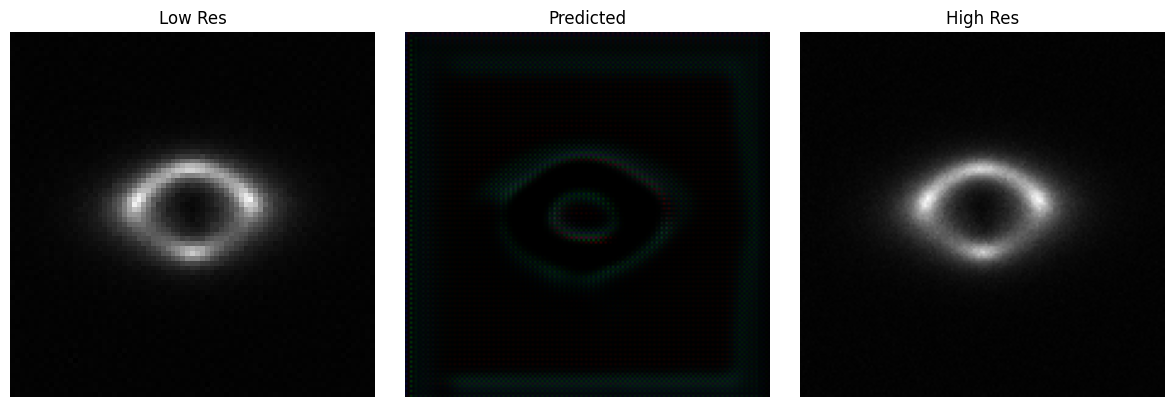

epoch  15 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

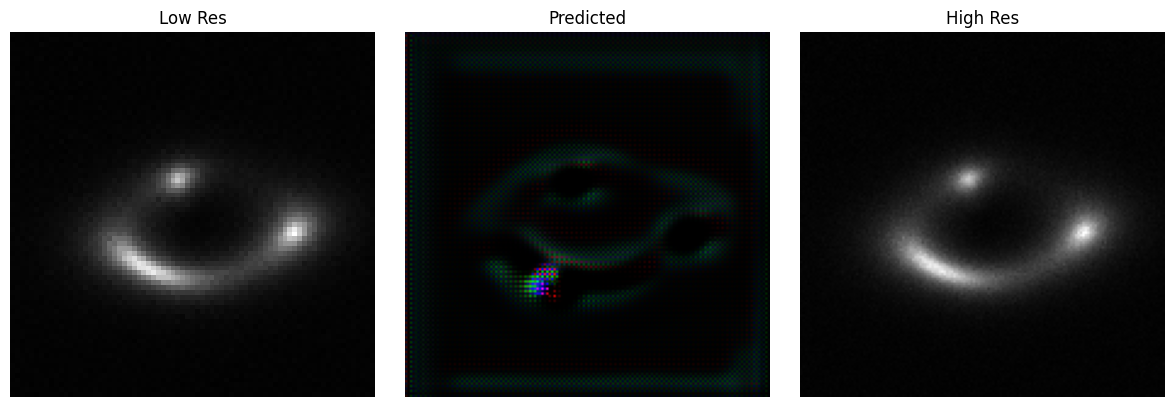

epoch  16 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

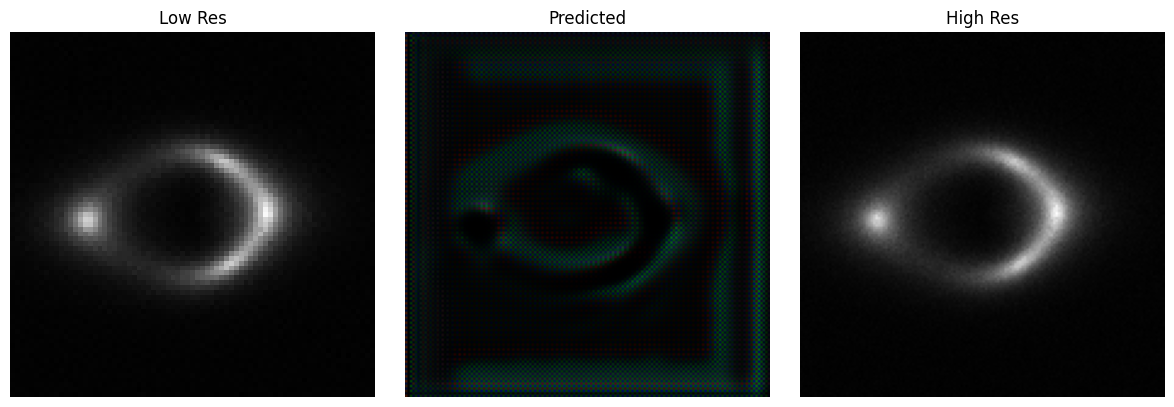

epoch  17 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

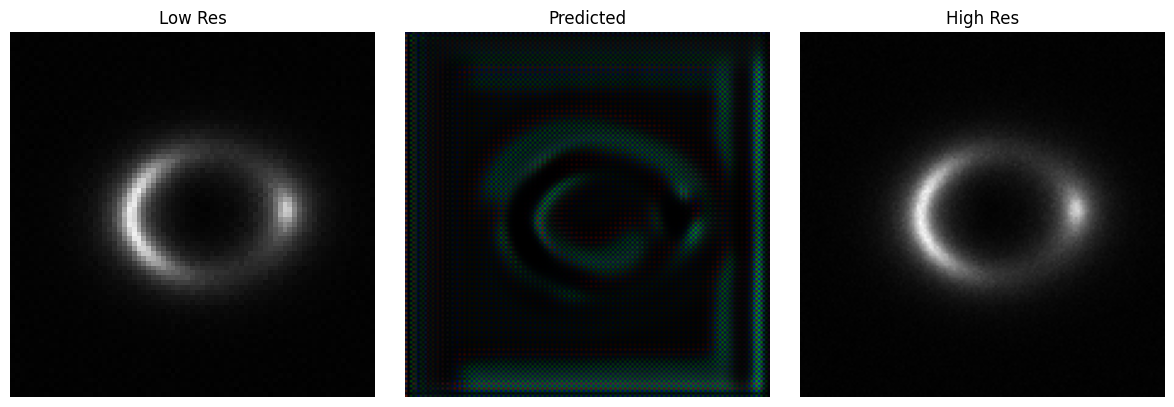

epoch  18 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

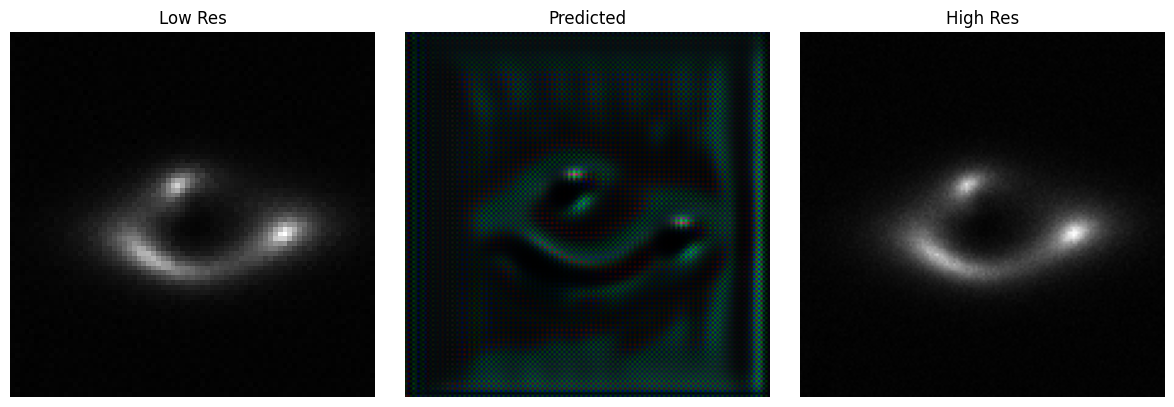

epoch  19 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

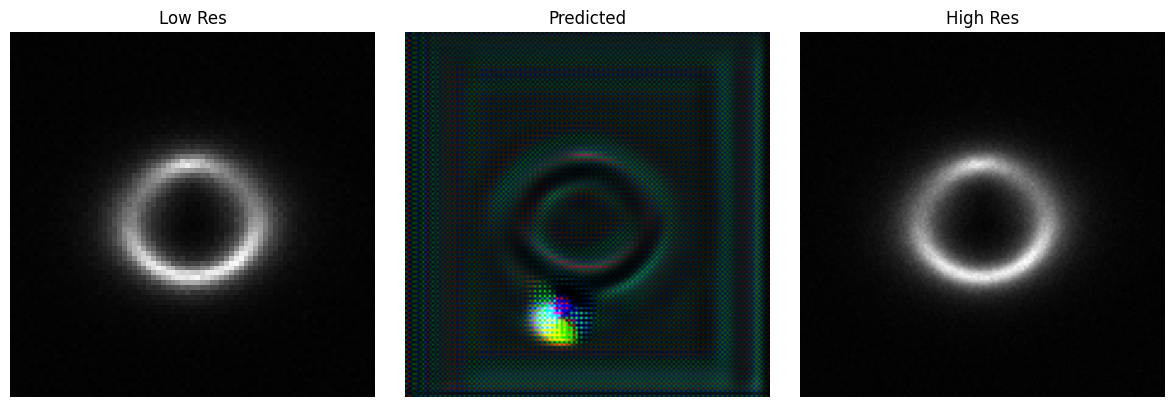

epoch  20 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

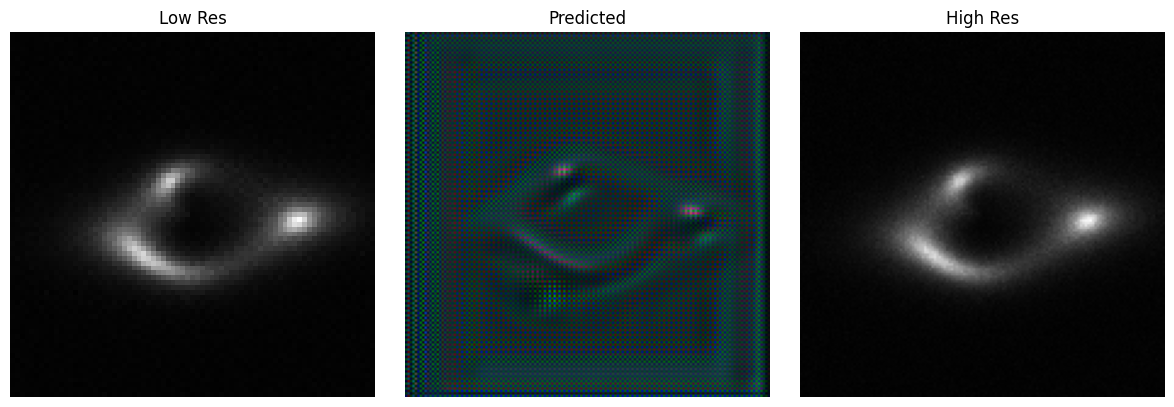

epoch  21 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

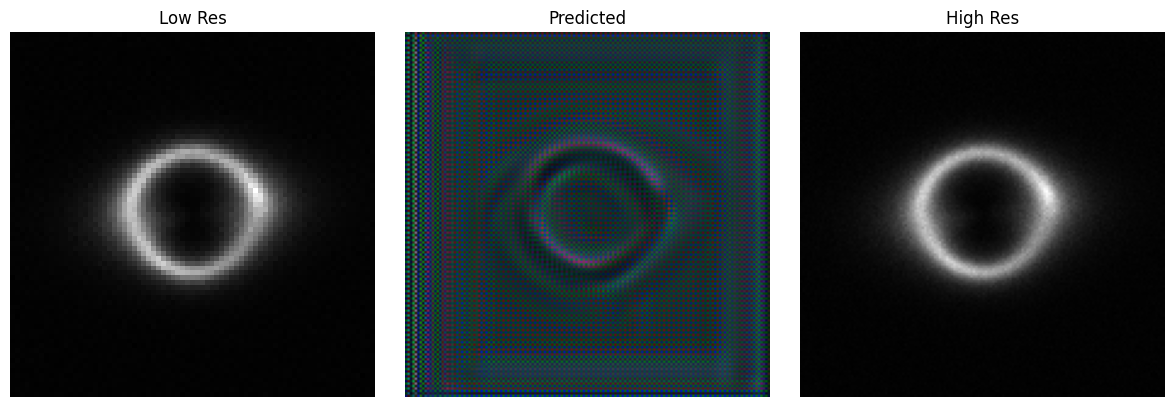

epoch  22 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

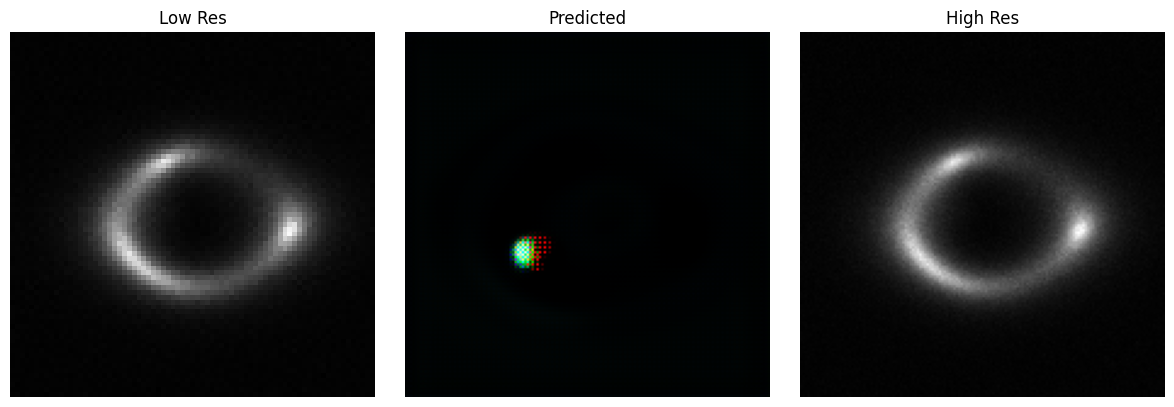

epoch  23 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

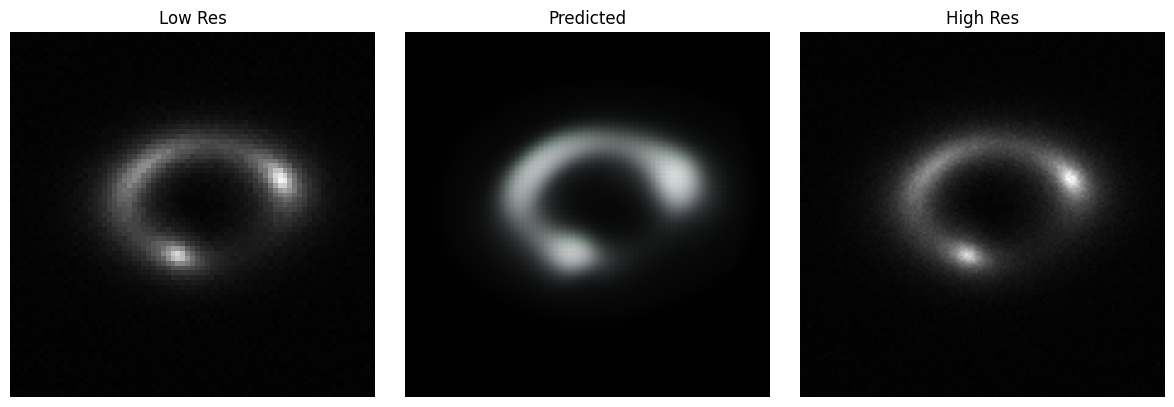

epoch  24 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

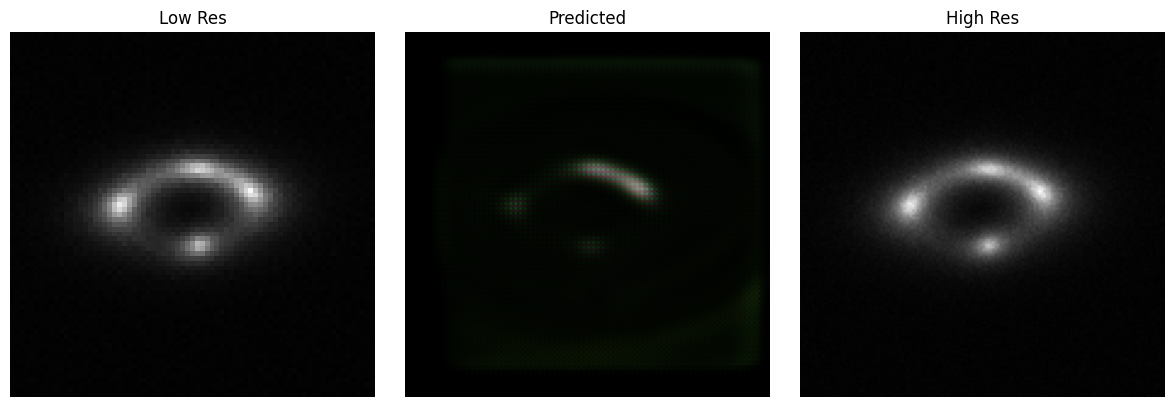

epoch  25 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

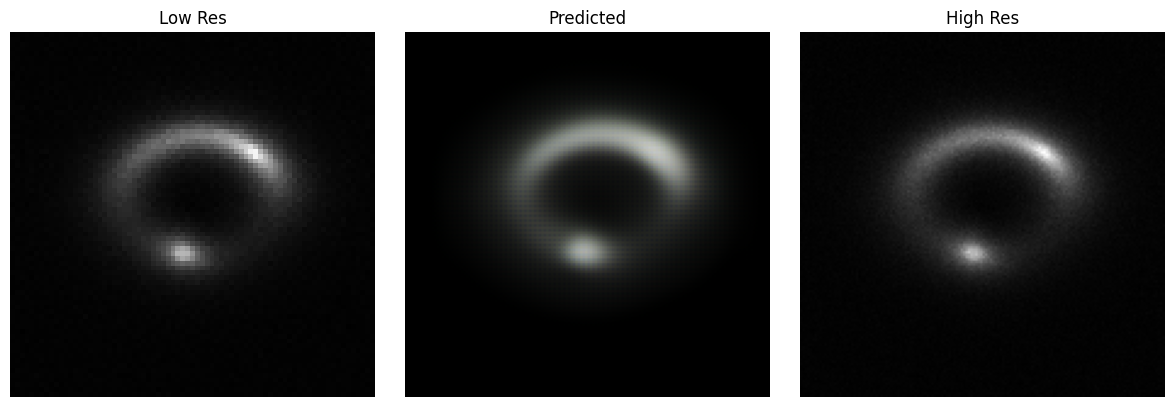

epoch  26 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

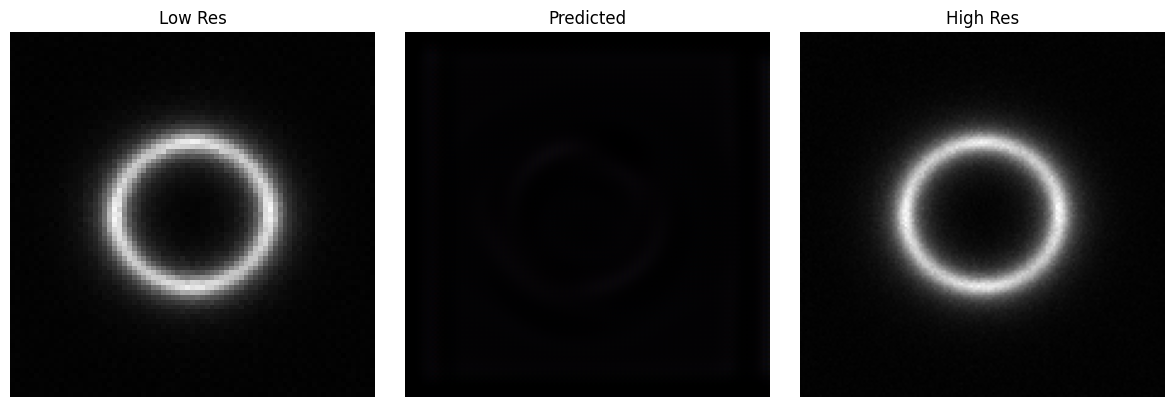

epoch  27 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

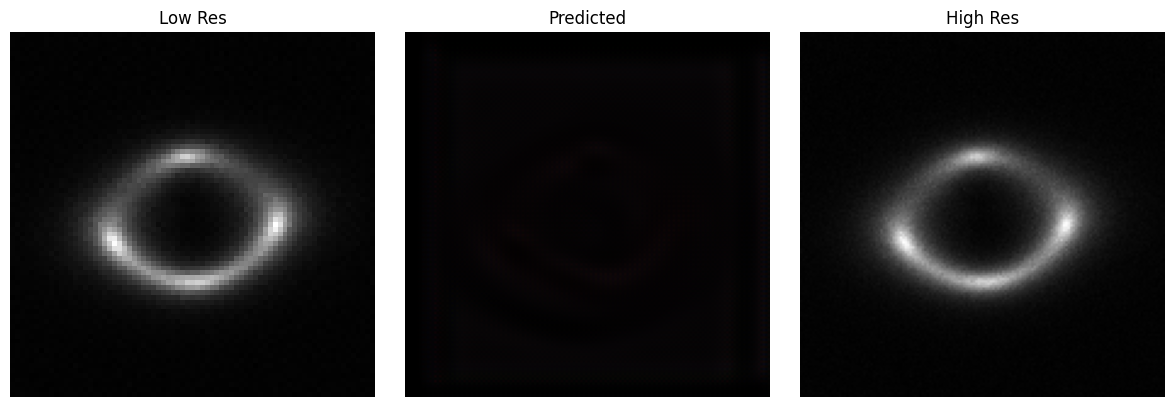

epoch  28 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

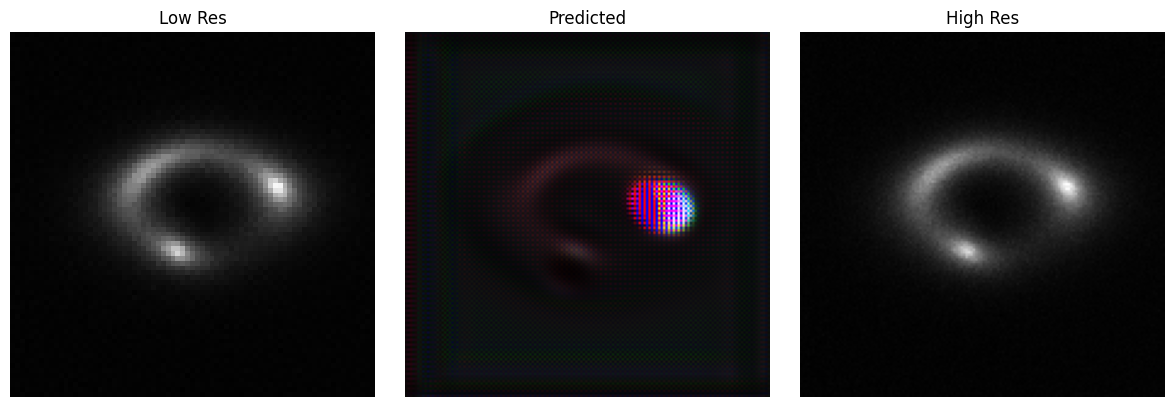

epoch  29 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

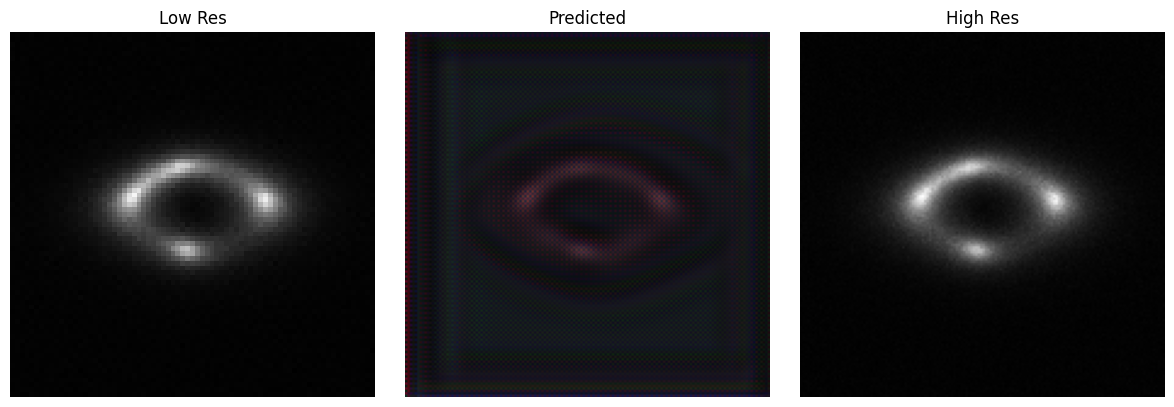

epoch  30 / 30


  0%|          | 0/625 [00:00<?, ?it/s]

In [20]:
d_losses = []
g_losses = []
for epoch in range(epochs):
     plot_examples(gen)
     print("epoch ", epoch+1, "/", epochs)
     gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
     # train discriminator and generator and update losses
     d_losses.append(disc_loss)
     g_losses.append(gen_loss)

In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def evaluate_metrics(gen, dataloader, dataset_name="Dataset"):
    gen.eval()
    psnr_scores = []
    ssim_scores = []
    mse_scores = []

    with torch.no_grad():
        for low_res, high_res in dataloader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            fake = gen(low_res)

            for i in range(fake.size(0)):
                pred = fake[i].detach().cpu().permute(1, 2, 0).numpy()
                gt = high_res[i].detach().cpu().permute(1, 2, 0).numpy()

                # Compute metrics
                psnr_val = psnr(gt, pred, data_range=1.0)
                ssim_val = ssim(gt, pred, channel_axis=-1, data_range=1.0)
                mse_val = F.mse_loss(fake[i], high_res[i]).item()

                psnr_scores.append(psnr_val)
                ssim_scores.append(ssim_val)
                mse_scores.append(mse_val)

    print(f"\n🔍 Evaluation Metrics on {dataset_name}:")
    print(f"• Avg MSE  : {sum(mse_scores) / len(mse_scores):.6f}")
    print(f"• Avg PSNR : {sum(psnr_scores) / len(psnr_scores):.2f} dB")
    print(f"• Avg SSIM : {sum(ssim_scores) / len(ssim_scores):.4f}")

    gen.train()  # Set back to training mode

evaluate_metrics(gen, train_loader, dataset_name="Train Set")
evaluate_metrics(gen, val_loader, dataset_name="Validation Set")


🔍 Evaluation Metrics on Train Set:
• Avg MSE  : 0.023090
• Avg PSNR : 16.50 dB
• Avg SSIM : 0.1480

🔍 Evaluation Metrics on Validation Set:
• Avg MSE  : 0.023090
• Avg PSNR : 16.50 dB
• Avg SSIM : 0.1480


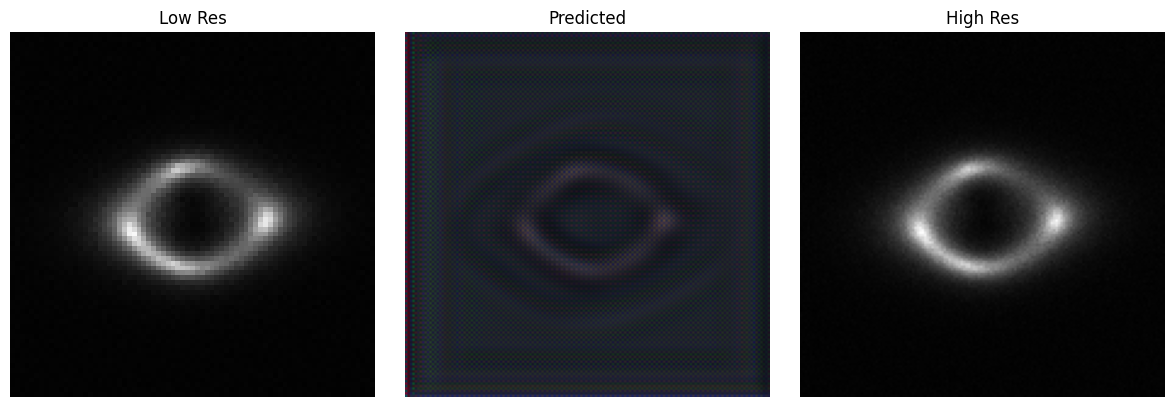

In [22]:
# print progress
plot_examples(gen)

In [23]:
# Save generator and discriminator weights after training
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")

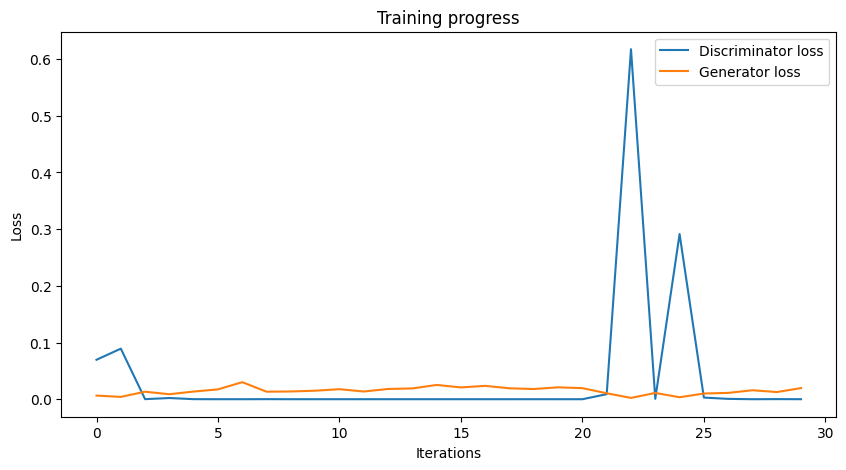

Epoch [29/30], Discriminator loss: 0.0000, Generator loss: 0.0196


In [24]:
train_progress(epoch, epochs, d_losses, g_losses)

In [25]:
# from torchvision import transforms
# import os
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, ToPILImage, Resize
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Augmented Dataset class
# class AugmentedNPYImageDataset(Dataset):
#     def __init__(self, root_dir):
#         self.hr_dir = os.path.join(root_dir, "HR")
#         self.lr_dir = os.path.join(root_dir, "LR")
#         self.hr_images = sorted(os.listdir(self.hr_dir))
#         self.lr_images = sorted(os.listdir(self.lr_dir))

#     def __len__(self):
#         return len(self.hr_images)

#     def __getitem__(self, idx):
#         hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
#         lr_path = os.path.join(self.lr_dir, self.lr_images[idx])

#         hr = torch.tensor(np.load(hr_path), dtype=torch.float32)
#         lr = torch.tensor(np.load(lr_path), dtype=torch.float32)

#         if hr.ndim == 2:
#             hr = hr.unsqueeze(0)
#         if lr.ndim == 2:
#             lr = lr.unsqueeze(0)

#         if hr.shape[0] == 1:
#             hr = hr.repeat(3, 1, 1)
#         if lr.shape[0] == 1:
#             lr = lr.repeat(3, 1, 1)

#         # Resize LR to match HR size
#         if lr.shape[1:] != hr.shape[1:]:
#             lr = transforms.Resize(hr.shape[1:])(ToPILImage()(lr))
#             lr = ToTensor()(lr)

#         # Convert HR to tensor via PIL for consistency
#         hr = ToTensor()(ToPILImage()(hr))

#         return lr, hr



# def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
#     loop = tqdm(loader)
#     total_disc_loss = 0
#     total_gen_loss = 0

#     for idx, (low_res, high_res) in enumerate(loop):
#         high_res = high_res.to(device)
#         low_res = low_res.to(device)

#         # Generate super-res
#         fake = gen(low_res)

#         # Train Discriminator
#         disc_real = disc(high_res)
#         disc_fake = disc(fake.detach())
#         loss_real = bce(disc_real, torch.ones_like(disc_real))
#         loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
#         disc_loss = loss_real + loss_fake

#         opt_disc.zero_grad()
#         disc_loss.backward()
#         opt_disc.step()

#         # Train Generator
#         disc_fake = disc(fake)
#         adversarial_loss = 1e-4 * bce(disc_fake, torch.ones_like(disc_fake))
#         perceptual_loss = 0.01 * vgg_loss(fake, high_res)
#         reconstruction_loss = mse(fake, high_res)
#         gen_loss = adversarial_loss + perceptual_loss + reconstruction_loss

#         opt_gen.zero_grad()
#         gen_loss.backward()
#         opt_gen.step()

#         total_disc_loss += disc_loss.item()
#         total_gen_loss += gen_loss.item()

#         loop.set_description(f"Gen: {gen_loss.item():.4f}, Disc: {disc_loss.item():.4f}")

#     avg_gen_loss = total_gen_loss / len(loader)
#     avg_disc_loss = total_disc_loss / len(loader)
#     return avg_gen_loss, avg_disc_loss


# # Load models
# gen.load_state_dict(torch.load("/kaggle/working/generator.pth", map_location=device))
# disc.load_state_dict(torch.load("/kaggle/working/discriminator.pth", map_location=device))

# gen.to(device)
# disc.to(device)

# # Optional: Freeze some generator layers
# for name, param in gen.named_parameters():
#     if "initial" in name or "residual" in name:
#         param.requires_grad = False

# # Dataset & loaders
# # train_dataset = AugmentedNPYImageDataset("/kaggle/input/sr-tunedata/Dataset", augment=True)
# # val_dataset = AugmentedNPYImageDataset("/kaggle/input/sr-tunedata/Dataset", augment=False)

# train_dataset = AugmentedNPYImageDataset("/kaggle/input/sr-tunedata/Dataset")
# val_dataset = AugmentedNPYImageDataset("/kaggle/input/sr-tunedata/Dataset")

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# # Training loop
# best_loss = float("inf")
# patience = 5
# counter = 0
# epochs = 20  # adjust as needed

# d_losses = []
# g_losses = []

# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)

#     d_losses.append(disc_loss)
#     g_losses.append(gen_loss)

#     if gen_loss < best_loss:
#         best_loss = gen_loss
#         counter = 0
#         torch.save(gen.state_dict(), "best_gen.pth")
#         torch.save(disc.state_dict(), "best_disc.pth")
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping triggered")
#             break


# def evaluate_srgan_on_new_data(gen):
#     dataset_test = AugmentedNPYImageDataset(root_dir="/kaggle/input/sr-tunedata/Dataset")
#     loader = DataLoader(dataset_test, batch_size=1)

#     gen.eval()
#     with torch.no_grad():
#         for i, (lr, hr) in enumerate(loader):
#             lr = lr.to(device)
#             sr = gen(lr)

#             fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#             axs[0].imshow(lr[0].permute(1, 2, 0).cpu())
#             axs[0].set_title("Low Res")
#             axs[1].imshow(sr[0].permute(1, 2, 0).cpu())
#             axs[1].set_title("Super Res")
#             axs[2].imshow(hr[0].permute(1, 2, 0).cpu())
#             axs[2].set_title("Ground Truth")
#             plt.show()

#             if i == 3:
#                 break
#     gen.train()

# evaluate_srgan_on_new_data(gen)
